In [1]:
import numpy as np

import os

In [2]:
rollout_dir = "/mnt/c/Users/narun/Desktop/Project/Heat_MGN/rollouts/testset"
testcases = os.listdir(rollout_dir)
rollouts = {}
for case in testcases :
    if case.startswith("triple") :
        rollouts[case] = np.load(os.path.join(rollout_dir, case, "rollout.npz"))


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=[0, 100, 200], cmap='viridis', point_size=4):
    """
    Scatter plot of predicted vs ground truth temperature for selected timesteps.
    Each timestep uses a different color, and a legend shows which color corresponds to which step.

    Args:
        pred (torch.Tensor or np.ndarray): shape (T, N) = (timesteps, nodes)
        gt (torch.Tensor or np.ndarray): same shape
        timesteps (list[int]): which timesteps to plot (e.g. [0, 100, 200])
        cmap (str): matplotlib colormap name
        point_size (int): size of scatter points
    """
    # Convert to numpy
    if hasattr(pred, 'detach'):
        pred = pred.detach().cpu().numpy()
    if hasattr(gt, 'detach'):
        gt = gt.detach().cpu().numpy()

    T, N = pred.shape
    timesteps = [t for t in timesteps if t < T]  # clip to available range

    colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors

    plt.figure(figsize=(6, 6))
    for i, t in enumerate(timesteps):
        plt.scatter(
            gt[t], pred[t],
            s=point_size,
            color=colors(i),
            alpha=0.6,
            label=f"Timestep {int((t+1)/pred.shape[0] * 100)}%"
        )

    # 45° reference line
    min_val = min(gt.min(), pred.min())
    max_val = max(gt.max(), pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.5)

    plt.xlabel("Ground Truth Temperature (K)")
    plt.ylabel("Predicted Temperature (K)")
    plt.title(f"Pred vs GT for the case {case_name.split('_')[0]}")
    plt.legend(markerscale=3, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [4]:
# for triple tracks case
case_name = "triple123_vx0.1_p150"
triple123 = rollouts[case_name]

/tmp/ipykernel_86812/3644871191.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors


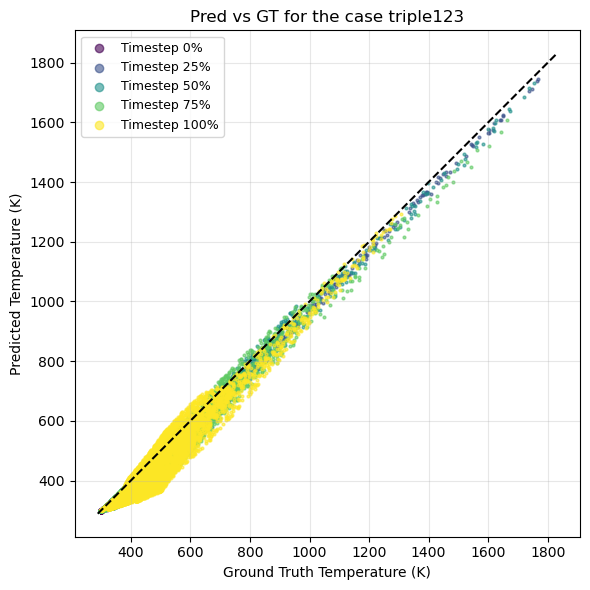

In [5]:
pred = triple123["pred"]
gt = triple123["gt"]
# selected_timesteps = [pred.shape[0]-1]
selected_timesteps = [0, int(pred.shape[0] * 0.25), int(pred.shape[0] * 0.5), int(pred.shape[0] * 0.75), pred.shape[0]-1]
plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=selected_timesteps, cmap='viridis', point_size=4)

In [6]:
data = triple123

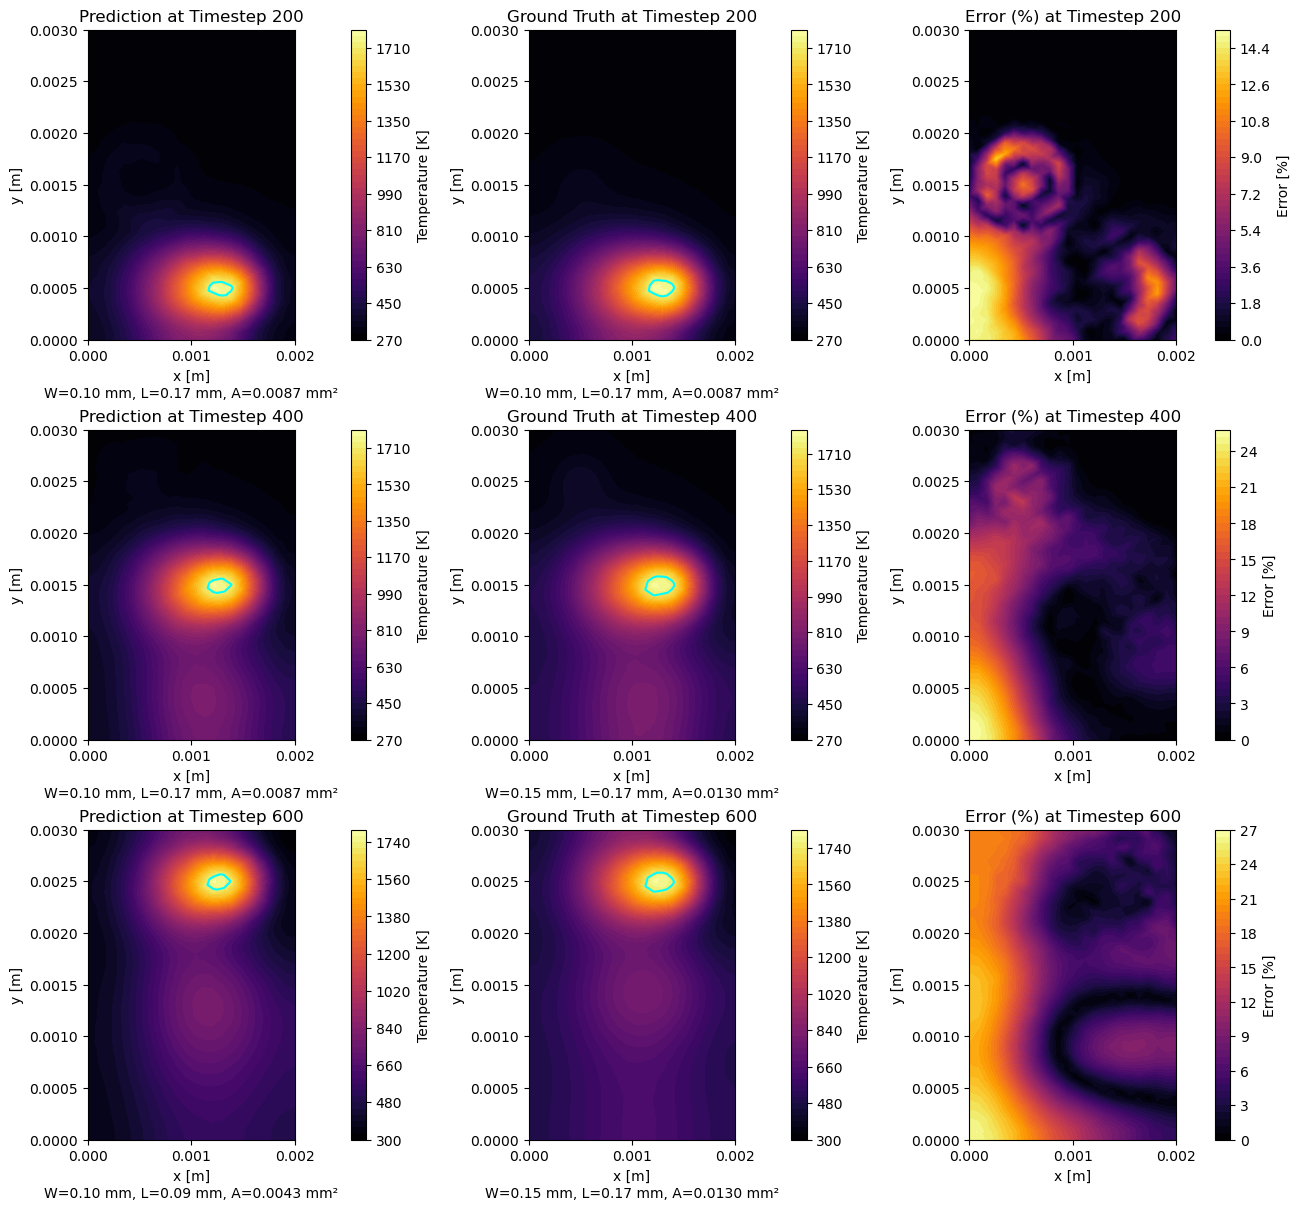

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Parameters ---
timesteps = [200, 400, 600]  # timesteps for each row
melting_point = 1716  # K
pred = data["pred"]
gt = data["gt"]
mesh_pos = data["mesh_pos"]

# --- Top surface ---
top_mask = mesh_pos[:, 2] == np.max(mesh_pos[:, 2])
top_domain = mesh_pos[top_mask]
x, y = top_domain[:, 0], top_domain[:, 1]

# --- Melt pool metrics ---
def meltpool_metrics(temp, domain, mp_temp):
    mask = temp >= mp_temp
    if np.any(mask):
        mp_pts = domain[mask]
        width = np.max(mp_pts[:, 1]) - np.min(mp_pts[:, 1])  # y-direction
        length = np.max(mp_pts[:, 0]) - np.min(mp_pts[:, 0])  # x-direction
        if mp_pts.shape[0] >= 3:
            try:
                area = ConvexHull(mp_pts[:, :2]).volume
            except:
                area = 0
        else:
            area = 0
    else:
        width, length, area = 0, 0, 0
    return mask, width, length, area

# --- Plot function ---
def plot_meltpool(ax, temp, mask, title, width=None, length=None, area=None):
    cf = ax.tricontourf(x, y, temp, levels=50, cmap='inferno')
    ax.tricontour(x, y, temp, levels=[melting_point], colors='cyan', linewidths=1.5)
    ax.set_aspect('equal')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(title)
    if width is not None and length is not None and area is not None:
        ax.text(0.5, -0.15,
                f"W={width*1e3:.2f} mm, L={length*1e3:.2f} mm, A={area*1e6:.4f} mm²",
                transform=ax.transAxes, ha='center', va='top', fontsize=10)
    return cf

# --- Create figure 3x3 ---
fig, axs = plt.subplots(len(timesteps), 3, figsize=(13, 12), constrained_layout=True)
colors = ['inferno']*3

for i, t in enumerate(timesteps):
    top_pred = pred[t, top_mask]
    top_gt = gt[t, top_mask]
    pred_mask, pred_width, pred_length, pred_area = meltpool_metrics(top_pred, top_domain, melting_point)
    gt_mask, gt_width, gt_length, gt_area = meltpool_metrics(top_gt, top_domain, melting_point)
    error_percent = 100 * np.abs(top_pred - top_gt) / np.maximum(np.abs(top_gt), 1e-8)

    # Column 1: Predicted
    cf1 = plot_meltpool(axs[i, 0], top_pred, pred_mask,
                        f"Prediction at Timestep {t}",
                        pred_width, pred_length, pred_area)
    fig.colorbar(cf1, ax=axs[i, 0], label="Temperature [K]")

    # Column 2: Ground Truth
    cf2 = plot_meltpool(axs[i, 1], top_gt, gt_mask,
                        f"Ground Truth at Timestep {t}",
                        gt_width, gt_length, gt_area)
    fig.colorbar(cf2, ax=axs[i, 1], label="Temperature [K]")

    # Column 3: Error %
    cf3 = axs[i, 2].tricontourf(x, y, error_percent, levels=50, cmap='inferno')
    axs[i, 2].set_aspect('equal')
    axs[i, 2].set_xlabel("x [m]")
    axs[i, 2].set_ylabel("y [m]")
    axs[i, 2].set_title(f"Error (%) at Timestep {t}")
    fig.colorbar(cf3, ax=axs[i, 2], label="Error [%]")

plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

melting_point = 1618  # K

def meltpool_metrics(temp, domain, mp_temp, plane='xy'):
    """
    Compute melt pool width, length, depth and area/volume.
    plane: 'xy' -> width in y, length in x
           'xz' -> width in z, length in x (for depth visualization)
    """
    mask = temp >= mp_temp
    if np.any(mask):
        mp_pts = domain[mask]
        if plane == 'xy':
            width = np.max(mp_pts[:, 1]) - np.min(mp_pts[:, 1])  # y-direction
            length = np.max(mp_pts[:, 0]) - np.min(mp_pts[:, 0])  # x-direction
            # Area in XY
            if mp_pts.shape[0] >= 3:
                try:
                    area = ConvexHull(mp_pts[:, :2]).volume
                except:
                    area = 0
            else:
                area = 0
            depth = None
            volume = None
        elif plane == 'xz':
            width = np.max(mp_pts[:, 2]) - np.min(mp_pts[:, 2])  # z-direction = depth
            length = np.max(mp_pts[:, 0]) - np.min(mp_pts[:, 0])  # x-direction
            if mp_pts.shape[0] >= 3:
                try:
                    volume = ConvexHull(mp_pts[:, [0,2]]).volume  # approximate 2D volume in xz
                except:
                    volume = 0
            else:
                volume = 0
            area = None
            depth = width
            width = None  # not relevant in side view
        else:
            raise ValueError("plane must be 'xy' or 'xz'")
    else:
        width = length = depth = area = volume = 0
    return mask, width, length, depth, area, volume

def plot_meltpool_timestep(pred, gt, mesh_pos, timestep, y_section=None):
    """
    Plot 2 rows x 3 columns for a given timestep:
      Row1: XY plane at top surface
      Row2: XZ plane at Y = Ly/2
      Columns: Predicted, Ground Truth, Error %
    """
    # --- Top surface mask ---
    top_mask = mesh_pos[:, 2] == np.max(mesh_pos[:, 2])
    top_domain = mesh_pos[top_mask]
    x_top, y_top = top_domain[:, 0], top_domain[:, 1]
    
    # --- Side view mask at y = Ly/2 ---
    # if Ly is None:
    #     Ly = np.max(mesh_pos[:,1])
    y_mid = y_section
    tol = 1e-6
    side_mask = np.abs(mesh_pos[:,1] - y_mid) < tol
    side_domain = mesh_pos[side_mask]
    x_side, z_side = side_domain[:,0], side_domain[:,2]
    
    # --- Temperature ---
    top_pred = pred[timestep, top_mask]
    top_gt = gt[timestep, top_mask]
    side_pred = pred[timestep, side_mask]
    side_gt = gt[timestep, side_mask]
    
    # --- Melt pool metrics ---
    tp_mask, tp_width, tp_length, _, tp_area, _ = meltpool_metrics(top_pred, top_domain, melting_point, plane='xy')
    tg_mask, tg_width, tg_length, _, tg_area, _ = meltpool_metrics(top_gt, top_domain, melting_point, plane='xy')
    
    sp_mask, _, sp_length, sp_depth, _, sp_volume = meltpool_metrics(side_pred, side_domain, melting_point, plane='xz')
    sg_mask, _, sg_length, sg_depth, _, sg_volume = meltpool_metrics(side_gt, side_domain, melting_point, plane='xz')
    
    # --- Error ---
    top_error = 100 * np.abs(top_pred - top_gt) / np.maximum(np.abs(top_gt), 1e-8)
    side_error = 100 * np.abs(side_pred - side_gt) / np.maximum(np.abs(side_gt), 1e-8)
    
    # --- Create figure ---
    fig, axs = plt.subplots(2,3, figsize=(15,10), constrained_layout=True)
    
    # --- Row1: XY Top view ---
    # Column1: Pred
    cf1 = axs[0,0].tricontourf(x_top, y_top, top_pred, levels=50, cmap='inferno')
    axs[0,0].tricontour(x_top, y_top, top_pred, levels=[melting_point], colors='cyan', linewidths=1.5)
    axs[0,0].set_aspect('equal')
    axs[0,0].set_xlabel('x [m]')
    axs[0,0].set_ylabel('y [m]')
    axs[0,0].set_title(f'Prediction XY at t={timestep}')
    axs[0,0].text(0.5, -0.15,
                  f"W={tp_width*1e3:.2f} mm, L={tp_length*1e3:.2f} mm, A={tp_area*1e6:.4f} mm²",
                  transform=axs[0,0].transAxes, ha='center', va='top', fontsize=10)
    fig.colorbar(cf1, ax=axs[0,0], label='Temperature [K]')
    
    # Column2: GT
    cf2 = axs[0,1].tricontourf(x_top, y_top, top_gt, levels=50, cmap='inferno')
    axs[0,1].tricontour(x_top, y_top, top_gt, levels=[melting_point], colors='cyan', linewidths=1.5)
    axs[0,1].set_aspect('equal')
    axs[0,1].set_xlabel('x [m]')
    axs[0,1].set_ylabel('y [m]')
    axs[0,1].set_title(f'Ground Truth XY at t={timestep}')
    axs[0,1].text(0.5, -0.15,
                  f"W={tg_width*1e3:.2f} mm, L={tg_length*1e3:.2f} mm, A={tg_area*1e6:.4f} mm²",
                  transform=axs[0,1].transAxes, ha='center', va='top', fontsize=10)
    fig.colorbar(cf2, ax=axs[0,1], label='Temperature [K]')
    
    # Column3: Error %
    cf3 = axs[0,2].tricontourf(x_top, y_top, top_error, levels=50, cmap='inferno')
    axs[0,2].set_aspect('equal')
    axs[0,2].set_xlabel('x [m]')
    axs[0,2].set_ylabel('y [m]')
    axs[0,2].set_title(f'Error XY (%) at t={timestep}')
    fig.colorbar(cf3, ax=axs[0,2], label='Error [%]')
    
    # --- Row2: XZ Side view ---
    # Column1: Pred
    cf4 = axs[1,0].tricontourf(x_side, z_side, side_pred, levels=50, cmap='inferno')
    axs[1,0].tricontour(x_side, z_side, side_pred, levels=[melting_point], colors='cyan', linewidths=1.5)
    axs[1,0].set_aspect('equal')
    axs[1,0].set_xlabel('x [m]')
    axs[1,0].set_ylabel('z [m]')
    axs[1,0].set_title(f'Prediction XZ at y={y_section:.3f}')
    axs[1,0].text(0.5, -0.15,
                  f"Depth={sp_depth*1e3:.2f} mm, L={sp_length*1e3:.2f} mm, V={sp_volume*1e6:.4f} mm²",
                  transform=axs[1,0].transAxes, ha='center', va='top', fontsize=10)
    fig.colorbar(cf4, ax=axs[1,0], label='Temperature [K]')
    
    # Column2: GT
    cf5 = axs[1,1].tricontourf(x_side, z_side, side_gt, levels=100, cmap='inferno')
    axs[1,1].tricontour(x_side, z_side, side_gt, levels=[melting_point], colors='cyan', linewidths=1.5)
    axs[1,1].scatter(x_side, z_side)
    axs[1,1].set_aspect('equal')
    axs[1,1].set_xlabel('x [m]')
    axs[1,1].set_ylabel('z [m]')
    axs[1,1].set_title(f'Ground Truth XZ at y={y_section:.3f}')
    axs[1,1].text(0.5, -0.15,
                  f"Depth={sg_depth*1e3:.2f} mm, L={sg_length*1e3:.2f} mm, V={sg_volume*1e6:.4f} mm²",
                  transform=axs[1,1].transAxes, ha='center', va='top', fontsize=10)
    fig.colorbar(cf5, ax=axs[1,1], label='Temperature [K]')
    
    # Column3: Error %
    cf6 = axs[1,2].tricontourf(x_side, z_side, side_error, levels=50, cmap='inferno')
    axs[1,2].set_aspect('equal')
    axs[1,2].set_xlabel('x [m]')
    axs[1,2].set_ylabel('z [m]')
    axs[1,2].set_title(f'Error XZ (%) at y={y_section:.3f}')
    fig.colorbar(cf6, ax=axs[1,2], label='Error [%]')
    
    plt.show()


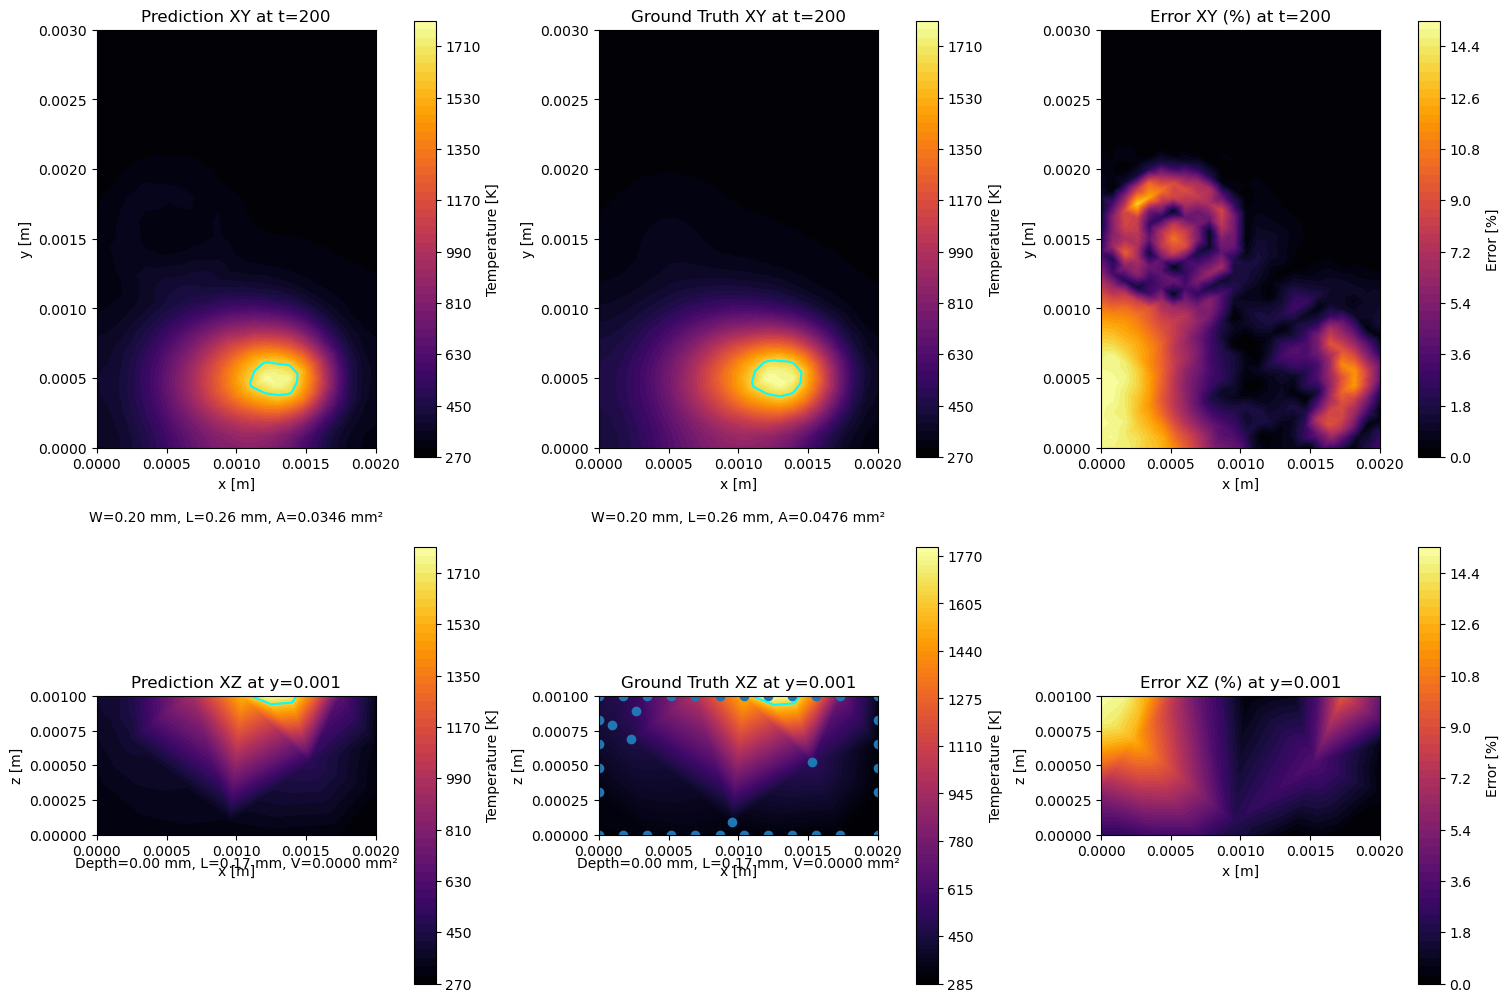

In [53]:
plot_meltpool_timestep(pred, gt, mesh_pos, timestep=200, y_section=5/30 * np.max(mesh_pos[:,1]))


In [245]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata

def plot_pred_gt_error(mesh_pos, pred, gt, timestep=0, y_val=0.0005,
                       nx=50, ny=50, nz=50, smooth=True, n_levels=50,
                       cbar_ticks=5, melt_T=1618):
    """
    Interpolates pred and gt from mesh nodes to a regular grid,
    plots XY (top) and XZ (at y=y_val) slices with error using contours,
    overlays meltpool contour at T=melt_T, and calculates meltpool dimensions and volume.
    Pred and GT share the same color scale; Error has its own.
    Meltpool dimensions/volume are displayed below each column.
    """
    pred_t = pred[timestep, :]
    gt_t = gt[timestep, :]

    # Interpolation grid
    x_lin = np.linspace(mesh_pos[:,0].min(), mesh_pos[:,0].max(), nx)
    y_lin = np.linspace(mesh_pos[:,1].min(), mesh_pos[:,1].max(), ny)
    z_lin = np.linspace(mesh_pos[:,2].min(), mesh_pos[:,2].max(), nz)
    X, Y, Z = np.meshgrid(x_lin, y_lin, z_lin, indexing='ij')

    # Interpolate
    grid_pred = griddata(mesh_pos, pred_t, (X, Y, Z), method='linear')
    grid_gt = griddata(mesh_pos, gt_t, (X, Y, Z), method='linear')
    grid_err = np.abs(grid_pred - grid_gt)

    # Compute meltpool dimensions function
    def compute_meltpool(grid, dx, dy, dz, threshold):
        mask = grid >= threshold
        if not mask.any():
            return 0,0,0,0
        x_coords = x_lin[np.any(np.any(mask, axis=1), axis=1)]
        y_coords = y_lin[np.any(np.any(mask, axis=0), axis=1)]
        z_coords = z_lin[np.any(np.any(mask, axis=0), axis=0)]
        melt_x = x_coords.max() - x_coords.min()
        melt_y = y_coords.max() - y_coords.min()
        melt_z = z_coords.max() - z_coords.min()
        melt_vol = np.sum(mask) * dx * dy * dz
        return melt_x, melt_y, melt_z, melt_vol

    dx = x_lin[1]-x_lin[0]; dy = y_lin[1]-y_lin[0]; dz = z_lin[1]-z_lin[0]
    melt_info = {}
    melt_info['$T_{pred}$'] = compute_meltpool(grid_pred, dx, dy, dz, melt_T)
    melt_info['$T_{gt}$']   = compute_meltpool(grid_gt, dx, dy, dz, melt_T)
    melt_info['Error']= (abs(melt_info['$T_{pred}$'][0] - melt_info['$T_{gt}$'][0])/melt_info['$T_{gt}$'][0] * 100, 
                         abs(melt_info['$T_{pred}$'][1] - melt_info['$T_{gt}$'][1])/melt_info['$T_{gt}$'][1] * 100, 
                         abs(melt_info['$T_{pred}$'][2] - melt_info['$T_{gt}$'][2])/melt_info['$T_{gt}$'][2] * 100, 
                         abs(melt_info['$T_{pred}$'][3] - melt_info['$T_{gt}$'][3])/melt_info['$T_{gt}$'][3] * 100)

    top_z_idx = -1
    y_idx = np.abs(y_lin - y_val).argmin()

    x_limits = (x_lin.min(), x_lin.max())
    y_limits = (y_lin.min(), y_lin.max())
    z_limits = (z_lin.min(), z_lin.max())

    fig = plt.figure(figsize=(15, 6))
    gs = GridSpec(2, 3, height_ratios=[3, 1], figure=fig, hspace=0.4)

    cols_data = [
        [grid_pred[:,:,top_z_idx], grid_pred[:,y_idx,:]],   # Pred
        [grid_gt[:,:,top_z_idx], grid_gt[:,y_idx,:]],       # GT
        [grid_err[:,:,top_z_idx], grid_err[:,y_idx,:]]      # Error
    ]
    cols_titles = ["$T_{pred}$", "$T_{gt}$", "Error (K)"]
    row_labels = ["on XY at top plane", f"on XZ at y = {y_val*1000:.2f} mm"]

    # Determine shared scale for Pred and GT (based on GT)
    pred_gt_vmin = np.nanmin(cols_data[1])
    pred_gt_vmax = np.nanmax(cols_data[1])

    for col_idx, (data_pair, title) in enumerate(zip(cols_data, cols_titles)):
        # Set vmin/vmax: Pred/GT use GT scale, Error has its own
        if title.startswith("Error"):
            vmin, vmax = np.nanmin(data_pair), np.nanmax(data_pair)
        else:
            vmin, vmax = pred_gt_vmin, pred_gt_vmax

        for row_idx, data_slice in enumerate(data_pair):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            cf = ax.contourf(
                x_lin, y_lin if row_idx==0 else z_lin, data_slice.T,
                levels=n_levels, cmap='viridis', vmin=vmin, vmax=vmax
            )
            ax.set_title(f"{title} {row_labels[row_idx]}")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits if row_idx==0 else z_limits)

            # Y-axis ticks only on left column
            if col_idx != 0:
                ax.set_yticks([])
            # X-axis ticks only on bottom row
            if row_idx != 1:
                ax.set_xticks([])

            # Overlay meltpool contour for Pred/GT only
            if not title.startswith("Error"):
                ax.contour(
                    x_lin, y_lin if row_idx==0 else z_lin, data_slice.T,
                    levels=[melt_T], colors='red', linewidths=1.5
                )

        # Colorbar below each column
        pos = ax.get_position()
        cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.07, pos.width, 0.02])
        cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Temperature (K)' if not title.startswith("Error") else 'Error (K)')
        # cbar.set_ticks(np.linspace(vmin, vmax, cbar_ticks))

        # Add meltpool info text below colorbar
        melt_x, melt_y, melt_z, melt_vol = melt_info[title.split()[0]]
        if title.split()[0] != "Error" :
            info_text = (f"Melt pool dimension $(x, y, z)$ = ({melt_x * 1000 :.2f}, {melt_y * 1000:.2f}, {melt_z* 1000:.2f}) mm\n"
                        f"Melt pool volume = {melt_vol* 1000**3:.2e} mm³")
        else :
            info_text = (f"Error Melt pool dimension $(x, y, z)$ = ({melt_x:.2f}, {melt_y:.2f}, {melt_z:.2f}) %\n"
                        f"Error Melt pool volume = {melt_vol:.2f} %")
        fig.text(pos.x0, pos.y0 - 0.15, info_text,
                 ha='left', va='top', fontsize=10)
    plt.suptitle(f"Temperature distribution (K) of the (1, 2, 3) triple-track case at timestep {int(timestep/pred.shape[0] * 100)} %")
    plt.show()


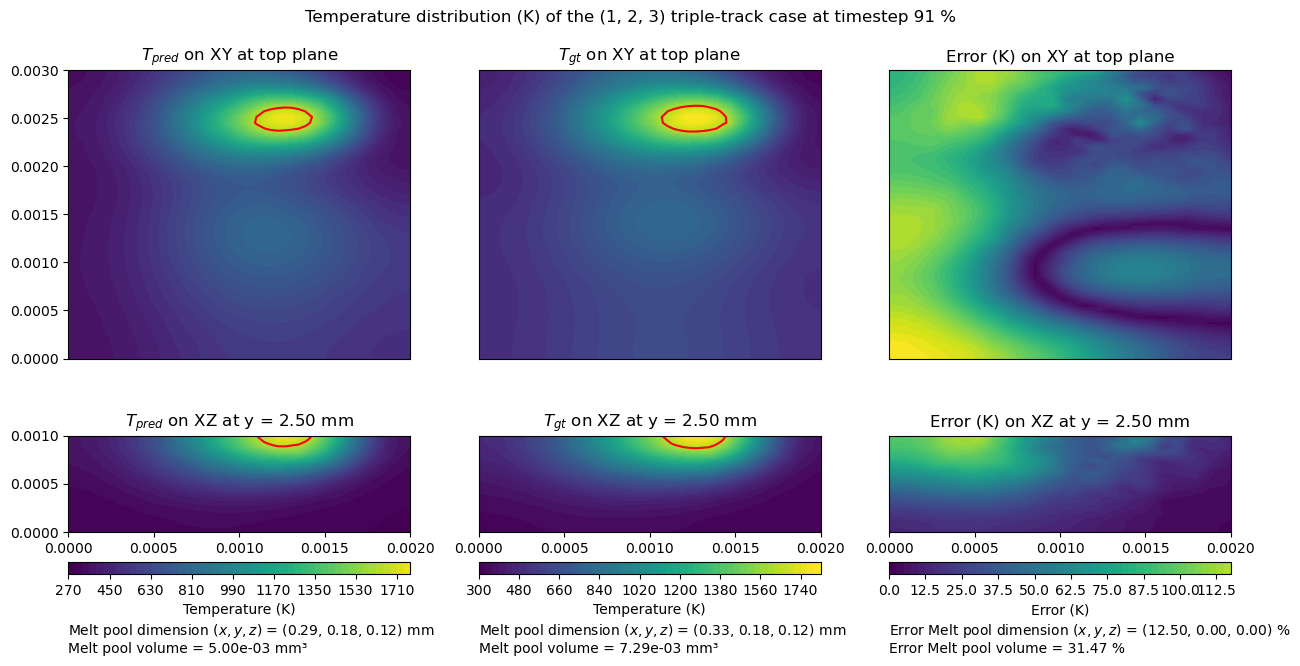

In [258]:
i = 2
timesteps = [150, 400, 600]
y_vals = [0.0005, 0.0015, 0.0025]
plot_pred_gt_error(mesh_pos=data["mesh_pos"],
                   pred=data["pred"],
                   gt=data["gt"],
                   timestep=timesteps[i],
                   y_val=y_vals[i],
                   nx=50, ny=50, nz=50,
                   smooth=True,
                   cbar_ticks=5)


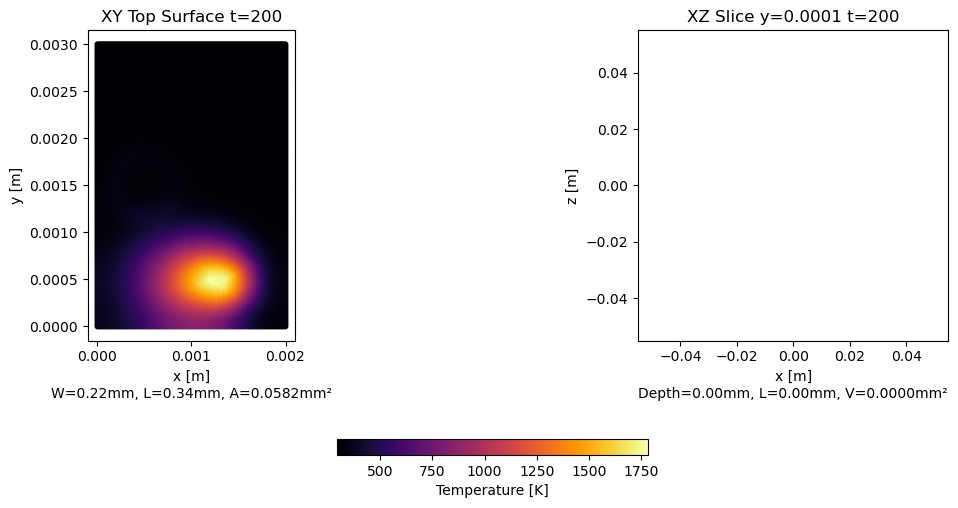

In [172]:
# timestep temperature vector and mesh positions
temp_t = pred[200]  # Nx1
X_grid, Y_grid, Z_grid, temp_grid = mesh_to_grid(mesh_pos, temp_t, grid_res=150)

plot_meltpool_from_grid(X_grid, Y_grid, Z_grid, temp_grid, timestep=200, y_section=0.0001)


In [67]:
timestep = -1
mid_top_y = (mesh_pos[:, 1] ==  mesh_pos[:, 1]/2) & (mesh_pos[:, 2] ==  np.max(mesh_pos[:, 2]))
mid_top_line = mesh_pos[mid_top_y]
pred_mid_line = pred[timestep, mid_top_y]
gt_mid_line = gt[timestep, mid_top_y]

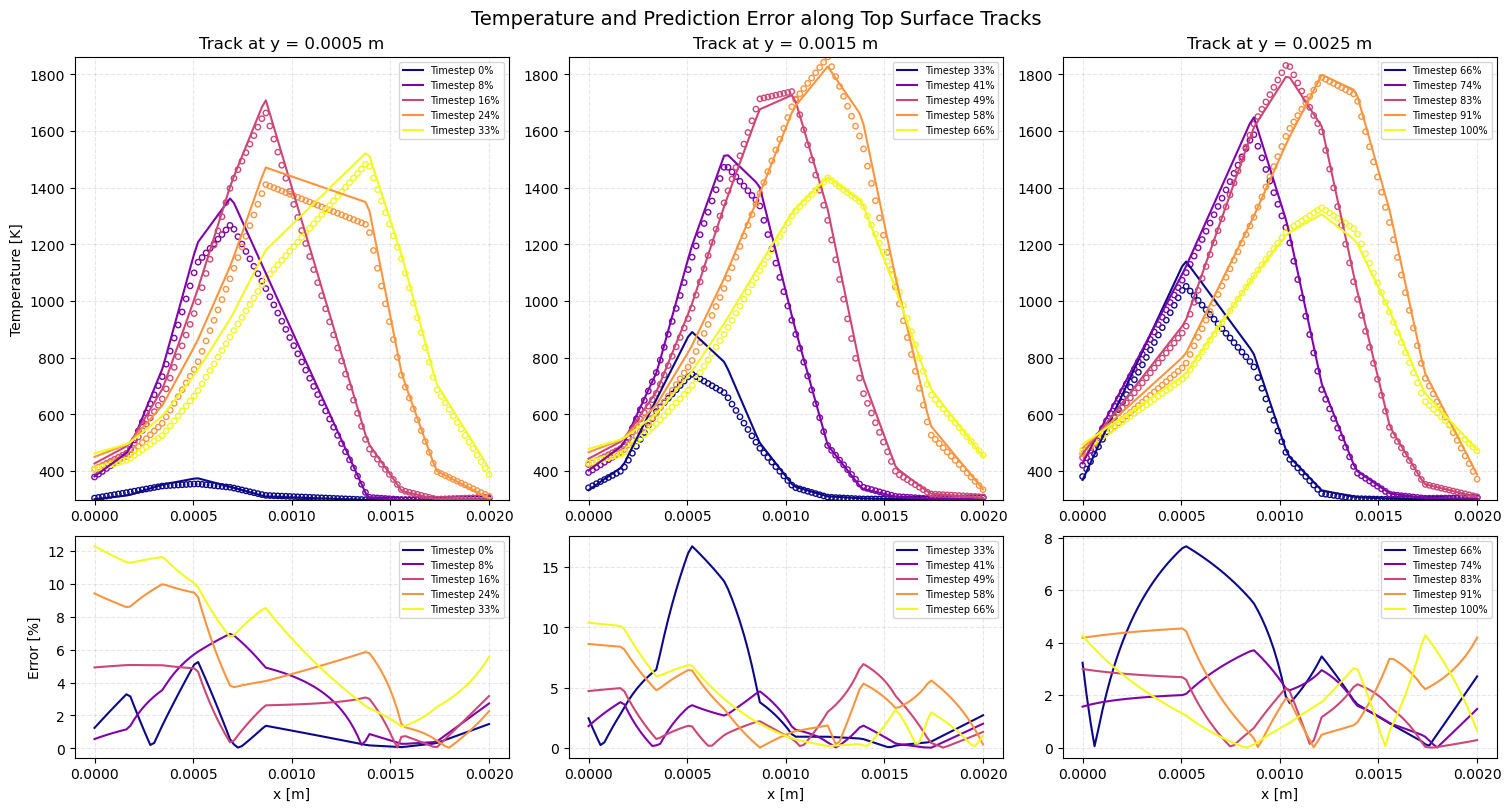

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

# --- Extract mesh and data ---
mesh_pos = data["mesh_pos"]
pred = data["pred"]
gt = data["gt"]

# --- Top surface coordinates ---
top_z = np.max(mesh_pos[:, 2])
L_y_min, L_y_max = np.min(mesh_pos[:, 1]), np.max(mesh_pos[:, 1])
track_positions = [L_y_min + f * (L_y_max - L_y_min) for f in [5/30, 15/30, 25/30]]

tol = 1e-8
x_min, x_max = np.min(mesh_pos[:, 0]), np.max(mesh_pos[:, 0])
x_interp = np.linspace(x_min, x_max, 100)

# --- Create figure (thinner bottom row) ---
fig, axs = plt.subplots(
    2, 3, figsize=(15, 8),
    gridspec_kw={'height_ratios': [2, 1]},  # thinner 2nd row
    constrained_layout=True
)

colors = plt.cm.plasma(np.linspace(0, 1, 5))

# For global y-limits on the top row
global_min, global_max = np.inf, -np.inf

# --- Precompute all interpolated data to find global y-limits ---
interp_data = []
for i, y_target in enumerate(track_positions):
    track_mask = (np.abs(mesh_pos[:, 1] - y_target) < tol) & (np.abs(mesh_pos[:, 2] - top_z) < tol)
    x_nodes = mesh_pos[track_mask, 0]
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    
    for t in timesteps_to_plot:
        pred_vals = pred[t, track_mask]
        gt_vals = gt[t, track_mask]
        pred_interp = griddata(x_nodes, pred_vals, x_interp, method='linear')
        gt_interp = griddata(x_nodes, gt_vals, x_interp, method='linear')
        interp_data.append((i, t, pred_interp, gt_interp))
        global_min = min(global_min, np.nanmin([pred_interp, gt_interp]))
        global_max = max(global_max, np.nanmax([pred_interp, gt_interp]))

# --- Plot using precomputed data ---
for i, y_target in enumerate(track_positions):
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    for color, (idx, t, pred_interp, gt_interp) in zip(colors, [d for d in interp_data if d[0] == i]):
        # --- Top row: Pred vs GT ---
        axs[0, i].scatter(x_interp, pred_interp, facecolors='none', edgecolors=color, s=15, linewidths=1)
        axs[0, i].plot(x_interp, gt_interp, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

        # --- Bottom row: Error [%] ---
        error = np.abs(pred_interp - gt_interp) / np.maximum(gt_interp, 1e-8) * 100
        axs[1, i].plot(x_interp, error, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

    # --- Style each column ---
    axs[0, i].set_title(f"Track at y = {y_target:.4f} m")
    axs[0, i].set_ylabel("Temperature [K]" if i == 0 else "")
    axs[1, i].set_ylabel("Error [%]" if i == 0 else "")
    axs[1, i].set_xlabel("x [m]")

    # Coarse tick marks
    axs[1, i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axs[0, i].xaxis.set_major_locator(MaxNLocator(nbins=5))

    # Grid + legends
    axs[0, i].grid(True, linestyle='--', alpha=0.3)
    axs[1, i].grid(True, linestyle='--', alpha=0.3)
    axs[0, i].legend(fontsize=7, loc='best')
    axs[1, i].legend(fontsize=7, loc='best')

# --- Apply uniform y-limits to first row ---
for ax in axs[0, :]:
    ax.set_ylim(global_min, global_max)

# --- Global title ---
fig.suptitle("Temperature and Prediction Error along Top Surface Tracks", fontsize=14)
plt.show()


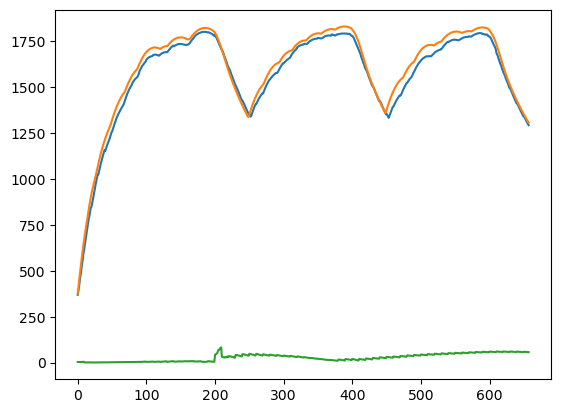

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Inputs ---
pred = data["pred"]
gt = data["gt"]
mesh_pos = data["mesh_pos"]

plt.plot(range(pred.shape[0]), np.max(pred, axis = 1))
plt.plot(range(pred.shape[0]), np.max(gt, axis = 1))
plt.plot(range(pred.shape[0]), np.max(pred-gt, axis = 1))

# plt.plot(range(pred.shape[0]), np.min(pred, axis = 1))
# plt.plot(range(pred.shape[0]), np.min(gt, axis = 1))
# plt.plot(range(pred.shape[0]), np.min(pred-gt, axis = 1))
